# What I know about the data already

I merged the data from the indego website https://www.rideindego.com/about/data/

The data ranges from the start of the program in the second quarter of 2015, to data from the second quarter of 2020. Per the website above trips shorter than 1 minute have been removed and trip length has been capped at 24 hours. Additionally all trips conducted by staff for testing purposes are removed here. These trips therefore are assumed to be actual customers and riders. I will keep this in mind as I consider outliers.

### Import Libraries and define custom features

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
from collections import Counter
pd.options.display.float_format = '{:.3f}'.format

In [2]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [3]:
def print_nulls(df):
    out = pd.Series({'Column': 'Percentage of nulls', '-----' : '-----'}
                   ).append(df.isnull().sum()*100/df.isnull().isnull().count())
   
    return out

In [4]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [5]:
def test_significance(df, cols):

    test_results = []

    for col in cols:
        kruskal_results = scipy.stats.kruskal(inactive_bikes[col], active_bikes[col])
        mood_results = scipy.stats.median_test(inactive_bikes[col], active_bikes[col])
        test_results.append((col, kruskal_results[0], kruskal_results[1], mood_results[0], mood_results[1]))


    results_frame = pd.DataFrame(data = test_results, columns=['Variable'
                                                               , 'Kurskal Coefficent', ' Kruskal p-value'
                                                              , 'Mood\'s Coefficent', 'Mood\'s p-value'])
    return results_frame

In [6]:
# Read the merged dataset
raw_data = pd.read_csv(r'data/indego/indego-trips-all.csv', parse_dates=[2,3])

/home/owen/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Use a copy of the data as read from file. Recopying is faster than reading from file again
df = raw_data.copy()

In [8]:
# Type errors indicate missing or imporperly typed data. The first task will be to correct these.

In [9]:
# Drop the unique identifier
df.drop('trip_id', axis=1, inplace=True)

In [10]:
# Inspect the frame to check that everything is properly imported

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594529 entries, 0 to 3594528
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   duration             int64         
 1   start_time           datetime64[ns]
 2   end_time             datetime64[ns]
 3   start_station_id     float64       
 4   start_lat            object        
 5   start_lon            object        
 6   end_station_id       float64       
 7   end_lat              object        
 8   end_lon              object        
 9   bike_id              object        
 10  plan_duration        float64       
 11  trip_route_category  object        
 12  passholder_type      object        
 13  start_station        float64       
 14  end_station          float64       
 15  bike_type            object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(8)
memory usage: 438.8+ MB


In [12]:
df.head()

,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type
0,60,2015-04-23 07:44:00,2015-04-23 07:45:00,3046.000,39.950,-75.145,3046.000,39.950,-75.145,3350.000,30.000,Round Trip,Indego30,nan,nan,NaN
1,60,2015-04-23 07:45:00,2015-04-23 07:46:00,3046.000,39.950,-75.145,3046.000,39.950,-75.145,3350.000,30.000,Round Trip,Indego30,nan,nan,NaN
2,120,2015-04-23 07:46:00,2015-04-23 07:48:00,3057.000,39.964,-75.180,3057.000,39.964,-75.180,3282.000,0.000,Round Trip,Walk-up,nan,nan,NaN
3,60,2015-04-23 10:13:00,2015-04-23 10:14:00,3004.000,39.954,-75.164,3004.000,39.954,-75.164,3350.000,30.000,Round Trip,Indego30,nan,nan,NaN
4,180,2015-04-23 10:14:00,2015-04-23 10:17:00,3004.000,39.954,-75.164,3004.000,39.954,-75.164,2716.000,30.000,Round Trip,Indego30,nan,nan,NaN


In [13]:
# Check to see which columns have null values
print_nulls(df)

Column                 Percentage of nulls
-----                                -----
duration                             0.000
start_time                           0.000
end_time                             0.000
start_station_id                    66.824
start_lat                            0.018
start_lon                            0.018
end_station_id                      66.823
end_lat                              0.871
end_lon                              0.871
bike_id                              0.025
plan_duration                        0.000
trip_route_category                  0.000
passholder_type                      0.001
start_station                       33.177
end_station                         33.177
bike_type                           60.489
dtype: object

# Data Cleaning
For each column I will identify and address any missing or problem values and correct the type errors where present.

In [14]:
# Bike_id values
problems = []
for val in df['bike_id']:
    try:
        float(val)
    except:
        problems.append(val)

Counter(problems)

Counter({'03556A': 22, 'delete me': 4})

In [15]:
# Here there are just a few badly formated values that are easily retrieved
index = df[df['bike_id'] == '03556A'].index
df.loc[index, 'bike_id'] = 3556

# 4 values asking to be deleted; we oblidge
index = df[df['bike_id'] == 'delete me'].index
df.drop(index, inplace=True)

df['bike_id'] = pd.to_numeric(df['bike_id'])

In [16]:
# Trip route category is categorical but easilly encoded
df['trip_route_category'].value_counts()

One Way       3299283
Round Trip     295242
Name: trip_route_category, dtype: int64

In [17]:
df['round_trip'] = df['trip_route_category'].apply(lambda x: 1 if x == 'Round Trip' else 0)
df.drop('trip_route_category', axis=1, inplace=True)


In [18]:
# The formatting on this column changed part way through the dataset
# Fill into one column from the other
mask = df['start_station'].isna()
df.loc[mask, 'start_station'] = df['start_station_id']

# and for the end stations
mask = df['end_station'].isna()
df.loc[mask, 'end_station'] = df['end_station_id']

# drop the other columns
df.drop(['start_station_id', 'end_station_id'], axis=1, inplace=True)

In [19]:
# For now passholder type and plan duration are not useful
df.drop(['passholder_type', 'plan_duration'], axis=1, inplace=True)

Missing data for the beginning and ending longitude and latitude of trips overlaps significantly with trips that involve station 3000. This is a virtual station used for system administration. In other cases these data might be outliers to be discarded but in this case these trips may be significant as an unusual trip might present more wear and tear on the bikes. For now I will aggregate the number of trips each bike makes to station 3000 then drop the rows since there is no way to impute the start and end locations. 

In [20]:
# Aggregate the trips to the virtual station by bike_id
trips_to_3000 = df[df['end_station'] == 3000
                  ].drop_duplicates(subset=['bike_id', 'end_time']
                                   ).groupby('bike_id').agg(trips_to_3000 = ('end_station', 'count'))

# And the trips from the virtual statoin by bike_id
trips_from_3000 = df[df['start_station'] == 3000].groupby('bike_id').agg(
    trips_from_3000 = ('start_station', 'count'))


# Join the data, later I will join it to the aggregated bike-wise data
_3000 = trips_from_3000.join(trips_to_3000)

# Write the data to file to use later
_3000.to_csv(r'_3000_trips.csv', index=False)

In [21]:
# Now the location data can be cleaned
# Luckily the problem is missing values in a small proportion of columns
 
cols = ['start_lat', 'start_lon', 'end_lat', 'end_lon']

# Loop through each of the coordinate columns and replace problem values with nulls, these will be dropped later
for col in cols:
    df[df[col] == r'\N'] = np.nan
    
    df[col] = pd.to_numeric(df[col])

# entries that have 0 listed for both end coordinates
index = df[df['end_lat'] == 0].index
df.drop(index, inplace=True)

# entries that have 0 listed for both start coordinates 
index = df[df['start_lat'] == 0].index
df.drop(index, inplace=True)

#Two entries have negative latitude values for the start and end, they can be retrieved
mask = df['start_lat'] < 0
df.loc[mask, 'start_lat'] = df.loc[mask, 'start_lat'] * -1


# Three entries where only the end latitude is negative
mask = df['end_lat'] < 0
df.loc[mask, 'end_lat'] = df.loc[mask, 'end_lat'] *-1

In [22]:
# Bike type column
# This column is introduced in 2018-q3 report. This is also when a second bike type was introduced
# Therefore we can assume that all the trips before that were on standard bikes. Nulls only appear for this 
# time before there were electric bikes so it is safe to fill all of them
df['bike_type'] = df['bike_type'].fillna('standard')

In [23]:
# Check to see how the dataframe looks now
print_nulls(df)


Column           Percentage of nulls
-----                          -----
duration                       0.041
start_time                     0.041
end_time                       0.041
start_lat                      0.059
start_lon                      0.059
end_lat                        0.914
end_lon                        0.914
bike_id                        0.066
start_station                  0.041
end_station                    0.041
bike_type                      0.000
round_trip                     0.041
dtype: object

In [24]:
df.tail()

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,start_station,end_station,bike_type,round_trip
3594524,14.000,2020-06-30 23:54:00,2020-07-01 00:08:00,39.953,-75.154,39.977,-75.158,18807.000,3050.000,3056.000,electric,0.000
3594525,12.000,2020-06-30 23:54:00,2020-07-01 00:06:00,39.932,-75.182,39.954,-75.161,19765.000,3053.000,3037.000,electric,0.000
3594526,21.000,2020-06-30 23:57:00,2020-07-01 00:18:00,39.954,-75.178,39.956,-75.190,3561.000,3061.000,3009.000,standard,0.000
3594527,84.000,2020-06-30 23:57:00,2020-07-01 01:21:00,39.964,-75.180,39.964,-75.180,5338.000,3057.000,3057.000,standard,1.000
3594528,19.000,2020-06-30 23:58:00,2020-07-01 00:17:00,39.954,-75.178,39.956,-75.190,2609.000,3061.000,3009.000,standard,0.000


In [25]:
# Drop the few remaining nulls
df = df.dropna()

In [26]:
# There are a small number of trips that appear to be duplicates
df[['start_time', 'bike_id']].duplicated().value_counts()

False    3552433
True        2135
dtype: int64

In [27]:
df = df.drop_duplicates(['start_time', 'bike_id'])

In [28]:
# What about trips that end at the same time at the same station?
df[['end_time', 'bike_id', 'end_station']].duplicated().value_counts()

False    3552287
True         146
dtype: int64

In [29]:
df = df.drop_duplicates(['end_time', 'bike_id'])

In [30]:
# Similarly to other changes in the formatting of the dataset over time some of the

In [31]:
df['duration'].describe()

count   3552226.000
mean        458.402
std        2155.006
min           1.000
25%           9.000
50%          20.000
75%         480.000
max       86400.000
Name: duration, dtype: float64

In [32]:
# As shown above, some of the duration values are in minutes and some in seconds
# 24 = 1440 minutes = 86400 seconds
# In this case it is easiest to recalculate the duration
df['duration'] = (df['end_time'] - df['start_time']).dt.seconds / 60

# A few trips with duration of less than 1 minture are retained. One of the assumptions of our data is
# it contains no trips shorter than 1 minute so I will drop these observations.
index = df[df['duration'] < 1].index
df.drop(index, inplace=True)

df['duration'] = df['duration'].astype('int64')

In [33]:
# While there is no good way to tell what the actual distance traveled we can use the recorded start and
# end points to get a minimum distance for each trip if not a truly good aproximation.
df['distance'] = df.apply(lambda x: geopy.distance.geodesic((x.start_lat,x.start_lon)
                                                         ,(x.end_lat,x.end_lon)).miles, axis=1)

In [34]:
# Calculate speed in miles per hour using the distance and duration columns
df['speed'] = df['distance']/df['duration'] * 60

In [36]:
# Round trips have no distance or speed because of the way these values were calculated.
# I will fill these values by using average speed to calculate distance from trip duration.

index = df[df['round_trip'] == 1].index

df.loc[index, 'speed'] = df['speed'].mean()
df.loc[index, 'distance']  = (df['speed'].mean()/60) * df['duration']

In [37]:
print('Percentage of data retained after cleaning: ', len(df)/len(raw_data) * 100)

Percentage of data retained after cleaning:  98.75391184769965


In [38]:
# Save the cleaned dataset to file 
df.to_csv(r'data/indego/indego-trips-cleaned.csv', index=False)

In [ ]:
df = pd.read_csv('data/indego/indego-trips-cleaned.csv', parse_dates=[1,2])

In [ ]:
_3000 = pd.read_csv('_3000_trips.csv')

### Aggregation and Reshaping
Here I will also do some basic calculations to create a few more features. 

In [39]:
df.head()

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,start_station,end_station,bike_type,round_trip,distance,speed
0,1,2015-04-23 07:44:00,2015-04-23 07:45:00,39.950,-75.145,39.950,-75.145,3350.000,3046.000,3046.000,standard,1.000,0.079,4.396
1,1,2015-04-23 07:45:00,2015-04-23 07:46:00,39.950,-75.145,39.950,-75.145,3350.000,3046.000,3046.000,standard,1.000,0.079,4.396
2,2,2015-04-23 07:46:00,2015-04-23 07:48:00,39.964,-75.180,39.964,-75.180,3282.000,3057.000,3057.000,standard,1.000,0.159,4.396
3,1,2015-04-23 10:13:00,2015-04-23 10:14:00,39.954,-75.164,39.954,-75.164,3350.000,3004.000,3004.000,standard,1.000,0.079,4.396
4,3,2015-04-23 10:14:00,2015-04-23 10:17:00,39.954,-75.164,39.954,-75.164,2716.000,3004.000,3004.000,standard,1.000,0.238,4.396


In [40]:
bikes = df.groupby('bike_id').agg(total_time=('duration',  'sum')
                                   , mean_time=('duration',  'mean')
                                  , trips = ('start_station',  'count')
                                  , total_distance = ('distance',  'sum')
                                   , mean_distance = ('distance',  'mean')
                                  , most_recent_trip = ('end_time',  'max')
                                   ,first_trip = ('end_time',  'min')
                                  , bike_type = ('bike_type', pd.Series.mode)
                                  , round_trip_rate = ('round_trip', 'mean')
                                  )

# Reset the index to pull bike_id into the columns
bikes = bikes.reset_index()

In [41]:
# Join the data about trips to the virutual station, retained earlier

bikes = bikes.join(_3000, on='bike_id')


# fill the null values from the join with 0
bikes.loc[:, ['trips_to_3000', 'trips_from_3000']
         ] = bikes.loc[:, ['trips_to_3000', 'trips_from_3000']].fillna(0)

In [42]:
# Calculate age using the bikes more recent trip rather than the present
bikes['age'] = bikes['most_recent_trip'] - bikes['first_trip']

# Calculate the age in minutes
bikes['age'] = ((bikes['age'].dt.days * 24 * 60) + (bikes['age'].dt.seconds / 60)).astype('int64')

# Calculate the percentage of time the bike is operating for
bikes['use_rate'] = bikes['total_time']/bikes['age'] * 100

In [43]:
# calculate speed in miles per hour
bikes['avg_speed'] = (bikes['total_distance'] / bikes['total_time']) * 60

In [44]:
bikes['electric'] = bikes['bike_type'].apply(lambda x: 1 if x == 'electric' else 0)
bikes.drop('bike_type', axis=1, inplace=True)

In [45]:
bikes.head()

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric
0,1.000,17,8.500,2,0.738,0.369,2019-09-27 13:04:00,2018-05-09 14:41:00,0.500,0.000,0.000,728543,0.002,2.605,0
1,3.000,9,9.000,1,0.713,0.713,2018-11-26 14:02:00,2018-11-26 14:02:00,1.000,0.000,0.000,0,inf,4.756,0
2,14.000,445,222.500,2,3.581,1.790,2018-03-11 16:51:00,2018-03-06 10:57:00,0.000,0.000,0.000,7554,5.891,0.483,0
3,42.000,3214,535.667,6,10.589,1.765,2020-06-25 14:07:00,2020-05-06 11:40:00,0.167,0.000,0.000,72147,4.455,0.198,0
4,43.000,1141,570.500,2,0.895,0.447,2020-02-06 10:08:00,2020-02-03 16:41:00,0.000,0.000,0.000,3927,29.055,0.047,0


### Encoding the target
Here because I do not have the actual data about bikes status I have to infer this. I have reached out to the company to see if they would be willing to provide more information but have not heard back yet. I will build the best model that I can with this limitation. Insights gained here may be useful on their own or give a place to begin from if I am able to get more of the data. 

Here I will assume that any bike that has not had a trip in the last 30 days for which the dataset covers. Bike age is calculated using the date of the last trip rather than.

In [46]:
index = bikes[df['end_time'].max() - bikes['most_recent_trip'] > pd.to_timedelta('90 days')].index

In [47]:
bikes[df['end_time'].max() - bikes['most_recent_trip'] > pd.to_timedelta('90 days')]

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric
0,1.000,17,8.500,2,0.738,0.369,2019-09-27 13:04:00,2018-05-09 14:41:00,0.500,0.000,0.000,728543,0.002,2.605,0
1,3.000,9,9.000,1,0.713,0.713,2018-11-26 14:02:00,2018-11-26 14:02:00,1.000,0.000,0.000,0,inf,4.756,0
2,14.000,445,222.500,2,3.581,1.790,2018-03-11 16:51:00,2018-03-06 10:57:00,0.000,0.000,0.000,7554,5.891,0.483,0
4,43.000,1141,570.500,2,0.895,0.447,2020-02-06 10:08:00,2020-02-03 16:41:00,0.000,0.000,0.000,3927,29.055,0.047,0
5,44.000,1247,415.667,3,5.683,1.894,2020-01-07 19:12:00,2019-12-11 14:52:43,0.333,0.000,0.000,39139,3.186,0.273,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,19674.000,11595,53.433,217,283.574,1.307,2019-07-30 15:10:00,2019-06-20 22:01:00,0.046,0.000,0.000,57189,20.275,1.467,1
1941,19676.000,256,17.067,15,18.912,1.261,2019-08-23 13:17:00,2019-08-20 23:04:00,0.133,0.000,0.000,3733,6.858,4.433,1
1976,20265.000,5164,30.922,167,186.755,1.118,2019-10-05 16:46:46,2019-08-24 21:07:00,0.108,0.000,0.000,60219,8.575,2.170,1
1977,26012.000,332,27.667,12,23.368,1.947,2015-04-30 15:33:00,2015-04-25 16:11:00,0.167,0.000,0.000,7162,4.636,4.223,0


In [48]:
bikes.loc[index, 'inactive'] = 1
bikes.loc[:, 'inactive'] = bikes.loc[:, 'inactive'].fillna(0)

In [49]:
bikes['inactive'].value_counts()

0.000    1520
1.000     459
Name: inactive, dtype: int64

## Outlying Bikes

In [50]:
percentiles = [0, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 100]

print('   Percentile   Duration')
for bound in percentiles:
    x = np.percentile(df['duration'], [bound])[0]
    
    print('       {}         {} minutes'.format(str(bound), x))

   Percentile   Duration
       0         1.0 minutes
       1         1.0 minutes
       2.5         2.0 minutes
       5         4.0 minutes
       10         5.0 minutes
       25         7.0 minutes
       50         12.0 minutes
       75         20.0 minutes
       90         38.0 minutes
       95         59.0 minutes
       97.5         90.0 minutes
       99         168.0 minutes
       100         1439.0 minutes


In [51]:
percentiles = [0, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 100]

print('   Percentile   Use Rate')
for bound in percentiles:
    x = np.percentile(bikes['use_rate'], [bound])[0]
    
    print('       {}         {}% '.format(str(bound), round(x, 2)))

   Percentile   Use Rate
       0         0.0% 
       1         1.48% 
       2.5         1.77% 
       5         1.93% 
       10         2.07% 
       25         2.27% 
       50         2.53% 
       75         3.21% 
       90         6.63% 
       95         9.45% 
       97.5         12.85% 
       99         15.96% 
       100         nan% 


/home/owen/bin/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [52]:
percentiles = [0, 1, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99, 100]

print('   Percentile   Trips')
for bound in percentiles:
    x = np.percentile(bikes['trips'], [bound])[0]
    
    print('       {}         {} '.format(str(bound), round(x, 2)))

   Percentile   Trips
       0         1.0 
       1         29.78 
       2.5         77.45 
       5         134.0 
       10         223.0 
       25         877.5 
       50         2004.0 
       75         2737.5 
       90         2981.2 
       95         3079.1 
       97.5         3148.55 
       99         3235.22 
       100         3921.0 


In [53]:
bikes[bikes['trips'] < 30]

,bike_id,total_time,mean_time,trips,total_distance,mean_distance,most_recent_trip,first_trip,round_trip_rate,trips_from_3000,trips_to_3000,age,use_rate,avg_speed,electric,inactive
0,1.000,17,8.500,2,0.738,0.369,2019-09-27 13:04:00,2018-05-09 14:41:00,0.500,0.000,0.000,728543,0.002,2.605,0,1.000
1,3.000,9,9.000,1,0.713,0.713,2018-11-26 14:02:00,2018-11-26 14:02:00,1.000,0.000,0.000,0,inf,4.756,0,1.000
2,14.000,445,222.500,2,3.581,1.790,2018-03-11 16:51:00,2018-03-06 10:57:00,0.000,0.000,0.000,7554,5.891,0.483,0,1.000
3,42.000,3214,535.667,6,10.589,1.765,2020-06-25 14:07:00,2020-05-06 11:40:00,0.167,0.000,0.000,72147,4.455,0.198,0,0.000
4,43.000,1141,570.500,2,0.895,0.447,2020-02-06 10:08:00,2020-02-03 16:41:00,0.000,0.000,0.000,3927,29.055,0.047,0,1.000
5,44.000,1247,415.667,3,5.683,1.894,2020-01-07 19:12:00,2019-12-11 14:52:43,0.333,0.000,0.000,39139,3.186,0.273,0,1.000
6,47.000,11,11.000,1,0.872,0.872,2019-12-04 13:16:53,2019-12-04 13:16:53,1.000,0.000,0.000,0,inf,4.756,0,1.000
932,5348.000,332,19.529,17,25.332,1.490,2016-05-02 20:20:00,2016-04-28 09:52:00,0.176,0.000,0.000,6388,5.197,4.578,0,1.000
1185,11825.000,65,9.286,7,7.087,1.012,2017-09-27 20:24:00,2017-09-26 16:10:00,0.000,0.000,0.000,1694,3.837,6.542,0,1.000
1461,14613.000,68,22.667,3,4.122,1.374,2018-08-05 21:02:00,2018-08-03 16:27:00,0.667,0.000,0.000,3155,2.155,3.637,0,1.000


Based upon a visual inspection of bikes with less than 30 trips I will eliminate only bikes with less than 10 trips. This also includes the single outlier with 100% use time. Here particularly I wish I had more meta data. An inspection of the bike_id values shows that the bikes may belong to series or release groups. There are only a few bikes that do not conform to this pattern, most of which are included in the bikes which have trips fewer than 30. 

In [54]:
before = len(bikes)

index = bikes[bikes['trips'] < 10].index
bikes.drop(index, inplace=True)

index = bikes[bikes['bike_id'] < 2000].index
bikes.drop(index, inplace=True)

dif = before - len(bikes)
ratio = dif/before * 100
print('Removed {} bikes, {}% of observations'.format(dif, ratio))

Removed 12 bikes, 0.6063668519454269% of observations


In [55]:
# Write the results to file
bikes.to_csv(r'data/indego/bikewise.csv', index=False)

## EDA

To Begin I will produce some basic visualizations, then proceed with Hypothesis testing to identify significantly different variables between the two populations.

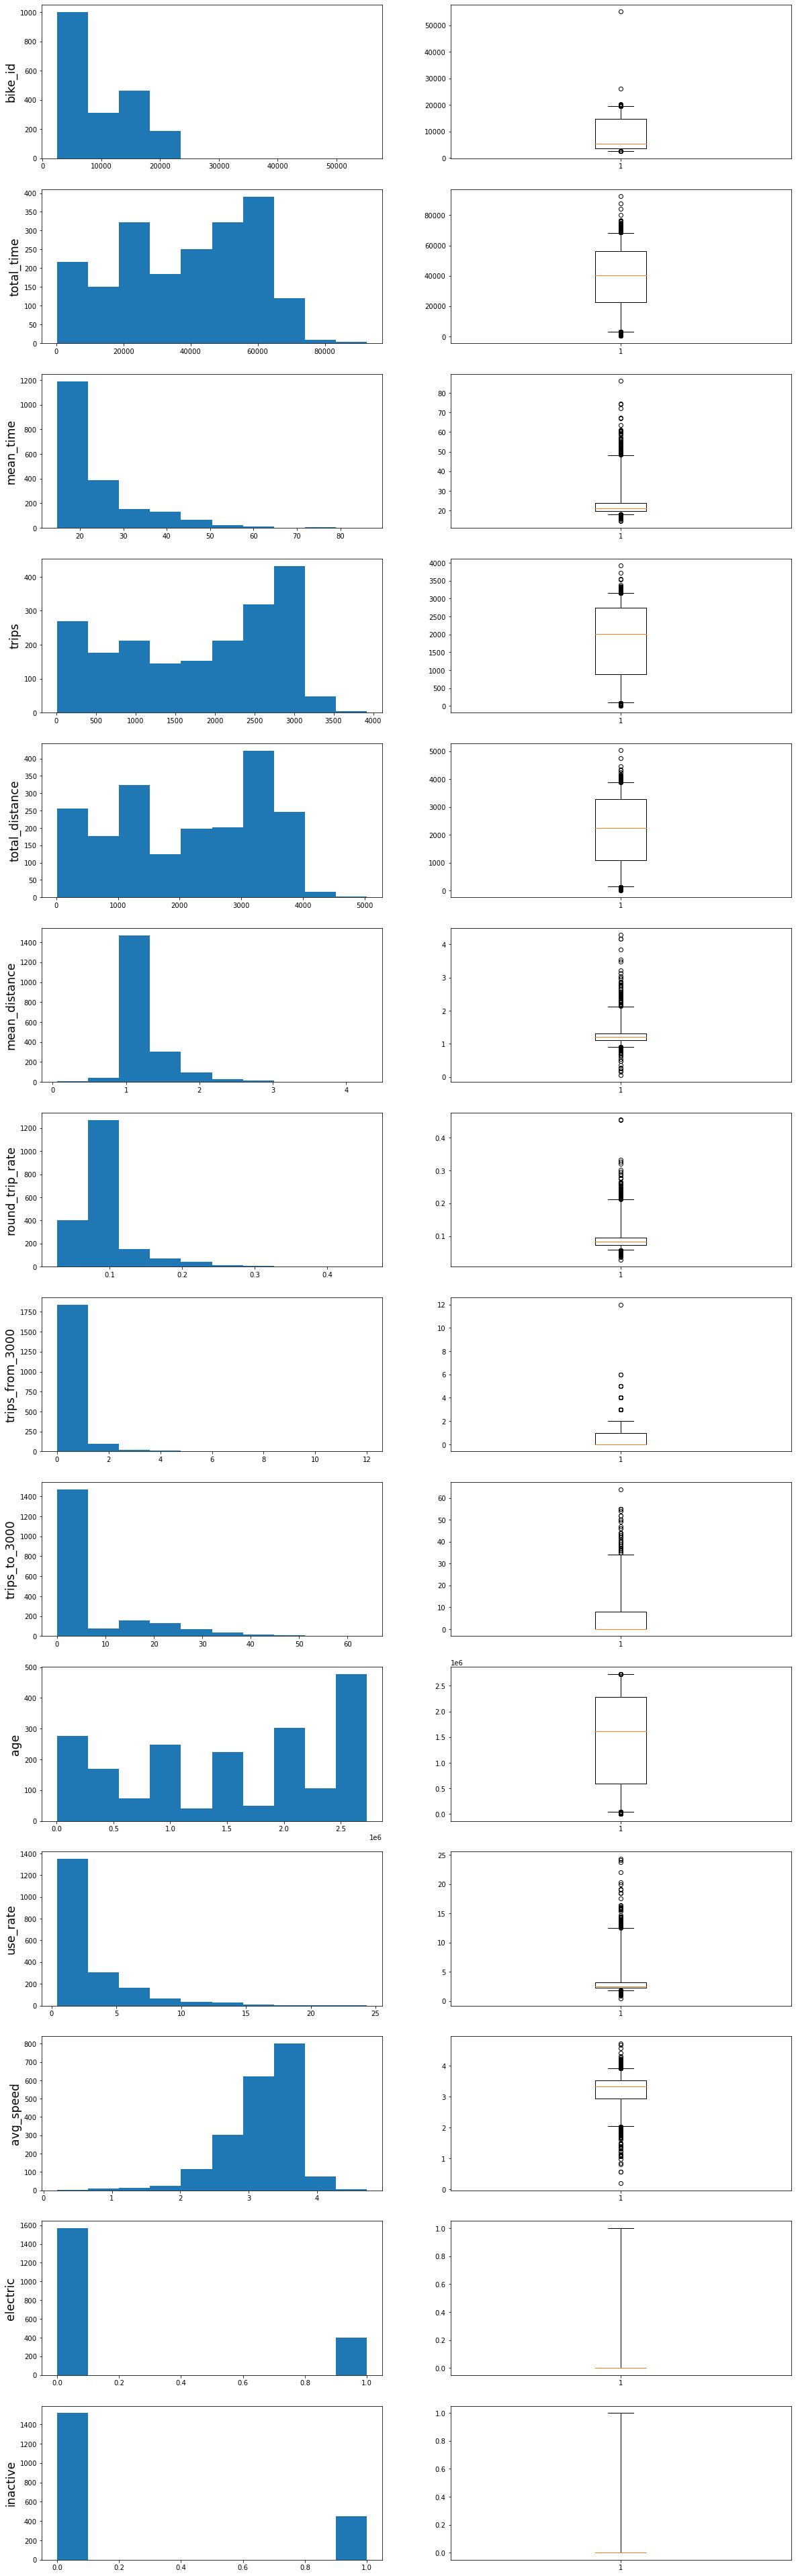

In [56]:
plot_hist_boxplot(bikes.select_dtypes(include='number'))

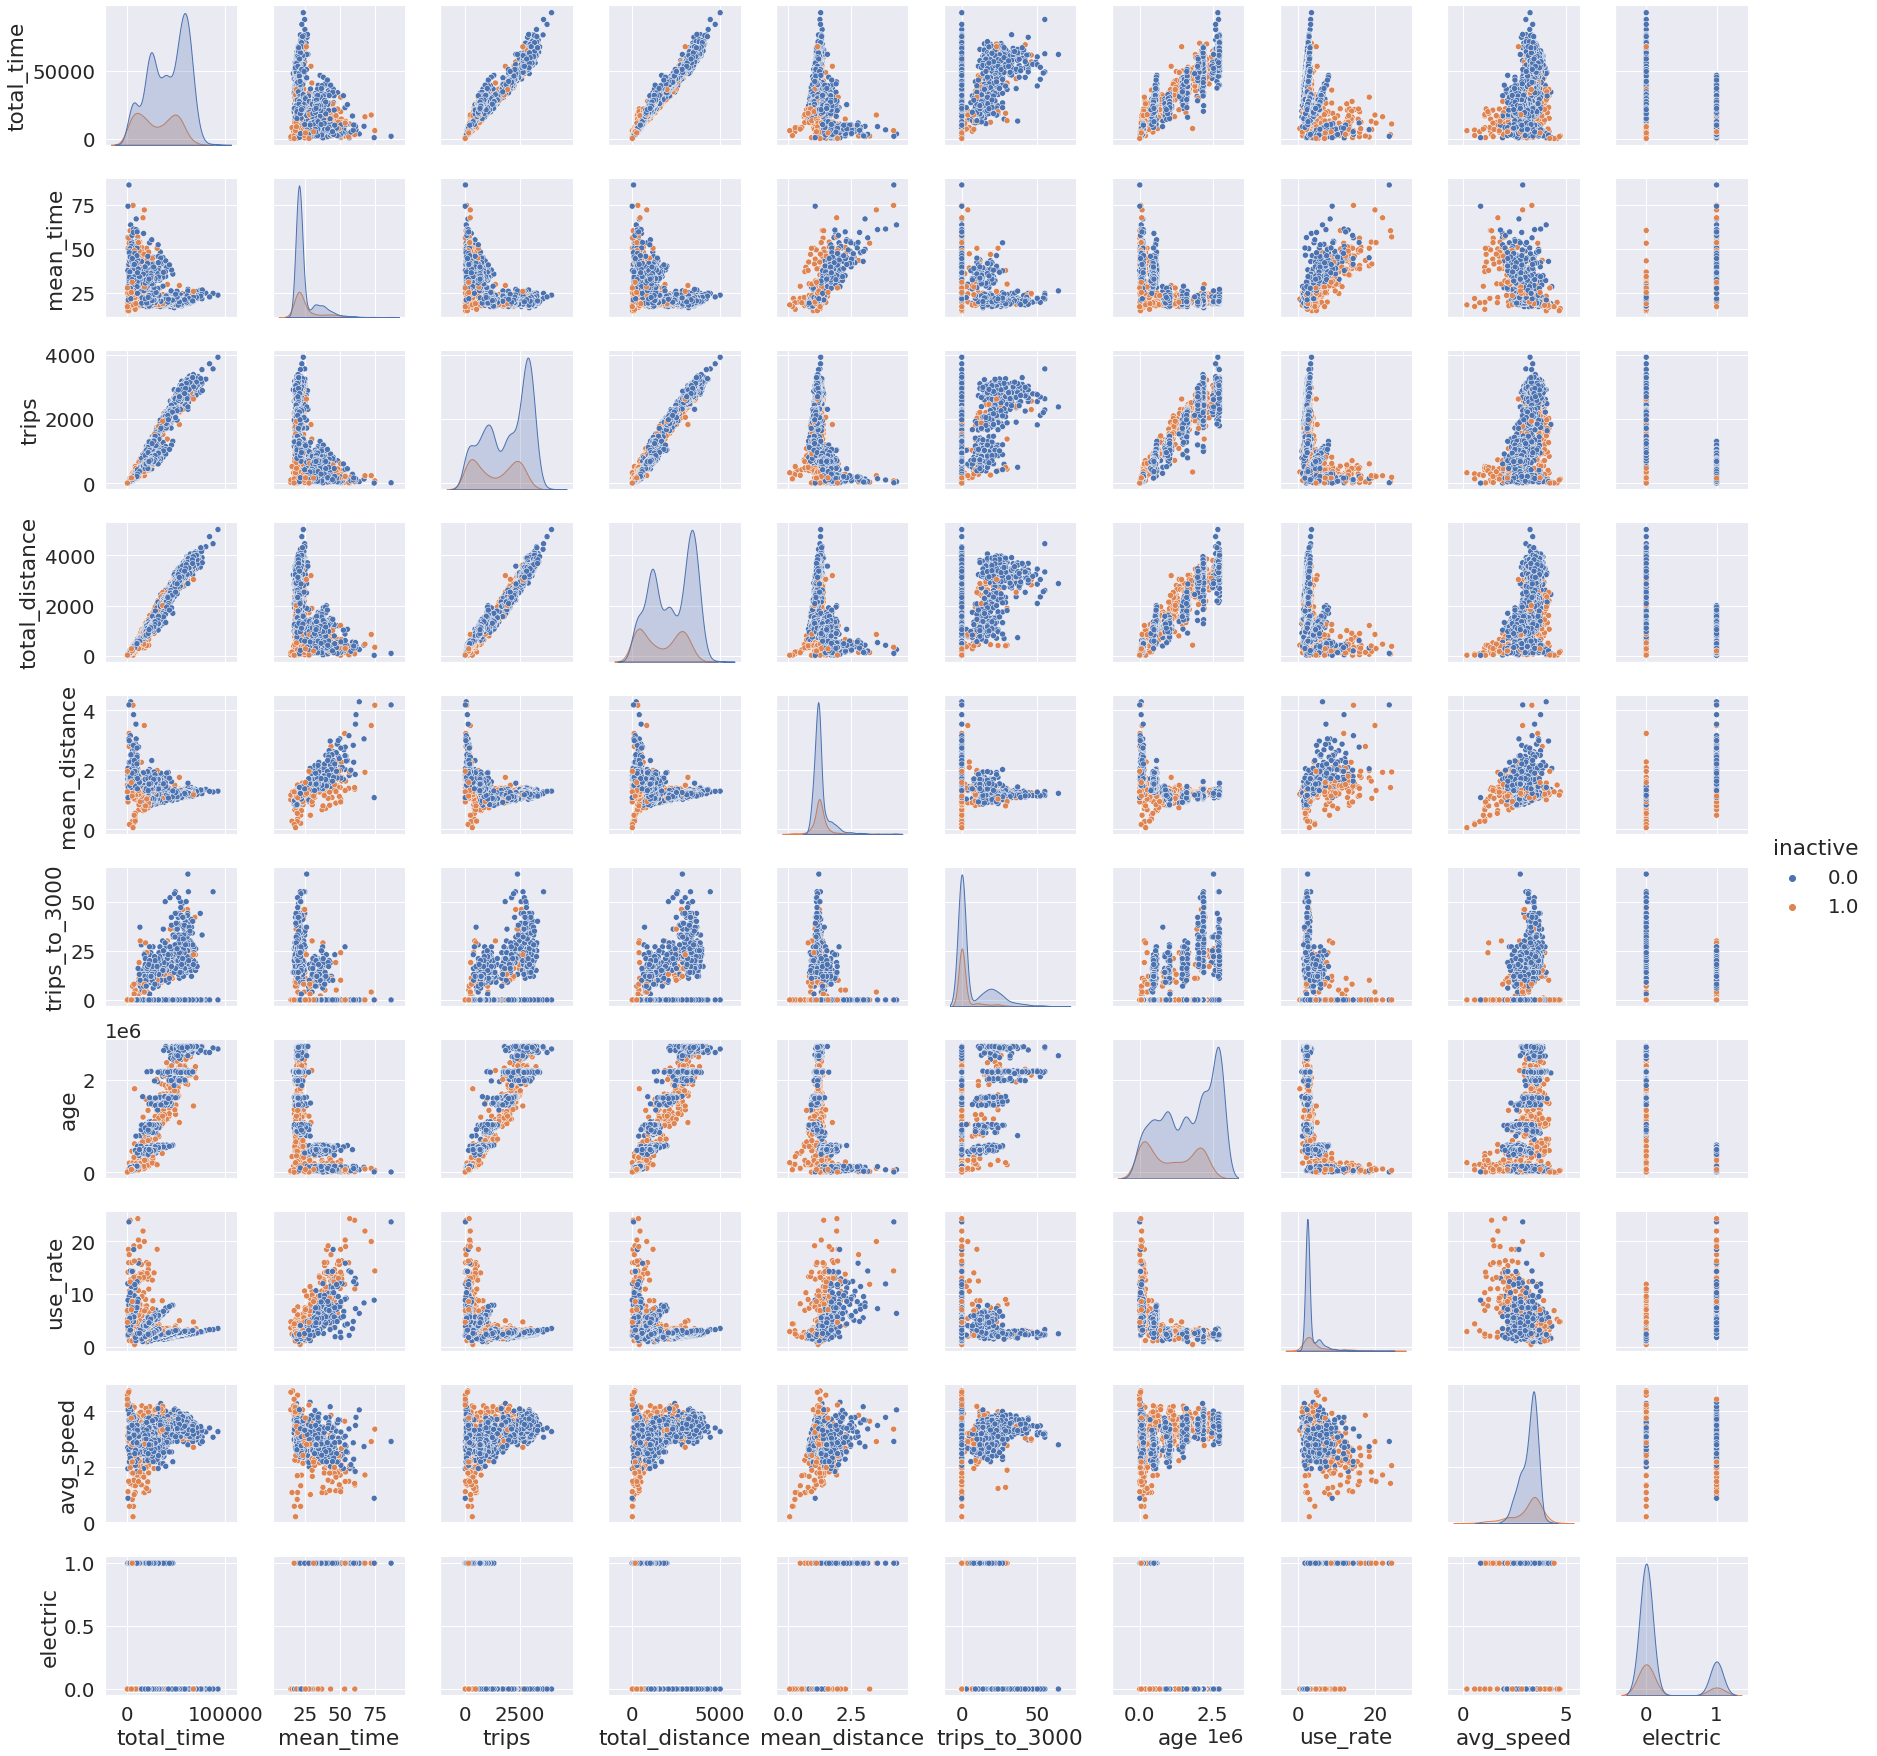

In [57]:
cols = ['total_time', 'mean_time', 'trips', 'total_distance',
       'mean_distance', 'trips_to_3000', 'age', 'use_rate', 'avg_speed', 'electric']
sns.set(font_scale=1.8)
sns.pairplot(bikes, vars=cols, hue='inactive')

<AxesSubplot:>

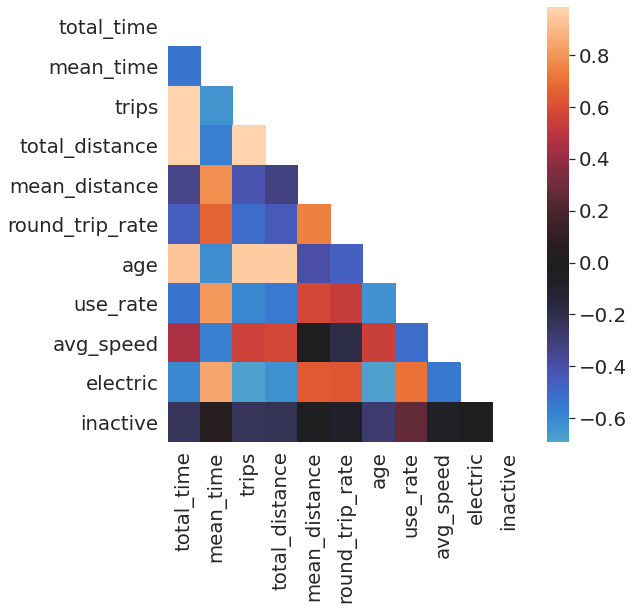

In [63]:
cols = ['total_time', 'mean_time', 'trips', 'total_distance', 'mean_distance', 'round_trip_rate'
        , 'age', 'use_rate', 'avg_speed', 'electric', 'inactive']
corr_map = bikes[cols].corr()

mask = np.zeros_like(corr_map, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr_map, center=0, mask=mask)

### Hypothesis Testing

None of the variables are normally distributed. In addition because the data still contains some outliers a Kruskal-Wallis may not be reliable. I will also include Mood's Median test and compare the results from each. Trips to 3000 and trips from 3000 do not contain enough variance to test.

Note that the critical value for both tests is 3.841.


In [58]:
# Create seperate data frames for each population
inactive_bikes = bikes[bikes['inactive'] == 1].copy()
active_bikes = bikes[bikes['inactive'] == 0].copy()

In [59]:
# Select the columns to be tested and use the function defined earlier to test for significance
cols = ['total_time', 'mean_time', 'trips', 'total_distance',
       'mean_distance', 'round_trip_rate', 'age', 'use_rate', 'avg_speed',
       'electric']

test_significance(bikes, cols)

,Variable,Kurskal Coefficent,Kruskal p-value,Mood's Coefficent,Mood's p-value
0,total_time,123.594,0.000,34.666,0.000
1,mean_time,1.342,0.247,0.758,0.384
2,trips,125.589,0.000,37.238,0.000
3,total_distance,117.350,0.000,17.400,0.000
4,mean_distance,11.291,0.001,15.009,0.000
5,round_trip_rate,6.735,0.009,0.399,0.528
6,age,166.214,0.000,48.449,0.000
7,use_rate,123.911,0.000,93.450,0.000
8,avg_speed,1.897,0.168,4.205,0.040
9,electric,0.016,0.900,0.003,0.953


There are some significant differences between several features in the active and inactive populations. The Kruskal and Mood tests agreed in most cases

Significant difference between the population in these variables according to both tests:
- total trip time
- trips
- total distance
- mean distance
- age
- use rate

No, or unclear significant difference between the populations in these variables:
- mean trip time
- round trip rate
- electric
- average speed

For the first group we reject the null hypothesis and accept the alternate hypothesis that there is a statistically significant difference between the two populations.

Text(0.5, 1.0, 'Distribution of Age')

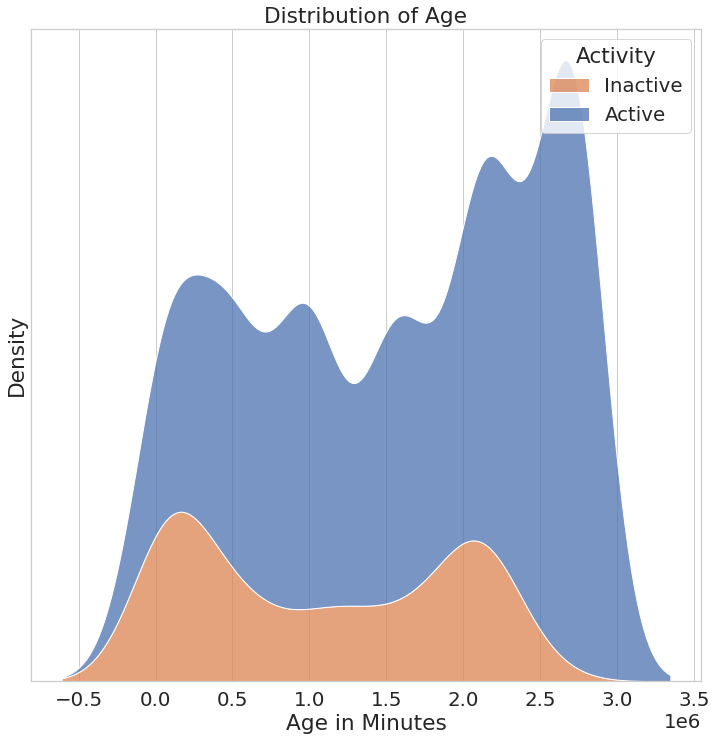

In [60]:
plt.figure(figsize=(12,12))
sns.set_style("whitegrid")
sns.kdeplot(x='age', hue='inactive', data=bikes, multiple='stack')

# title
plt.legend(title='Activity', labels=['Inactive', 'Active'])
plt.yticks([])
plt.xlabel('Age in Minutes')
plt.title('Distribution of Age')

This visualization defies my expectations because active bikes are older than inactive bikes. This suggests that perhaps there are other stronger risk factors than age which we might have expected to be a strong predictor. We do see the expected bathtub curve for failures.

Text(0.5, 1.0, 'Percentage of Operational Time in Use')

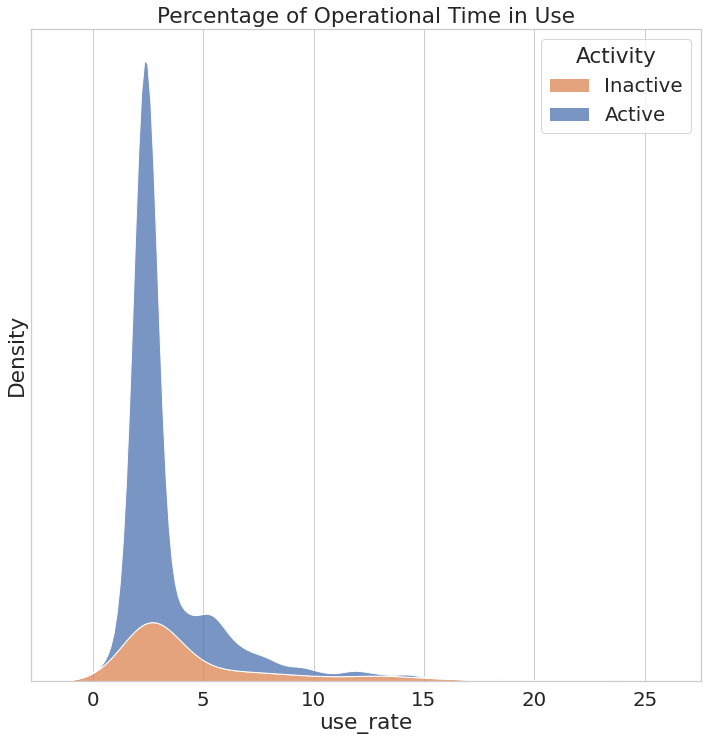

In [61]:
plt.figure(figsize=(12,12))
sns.set_style("whitegrid")
sns.kdeplot(x='use_rate', hue='inactive', data=bikes, multiple='stack')

# title
plt.legend(title='Activity', labels=['Inactive', 'Active'])
plt.yticks([])
plt.title('Percentage of Operational Time in Use')

This visualization indicates that a low use rate is a problem for the whole program, making this project perhaps even more important. Additionally we also see that inactive bikes have fatter tails than active bikes.

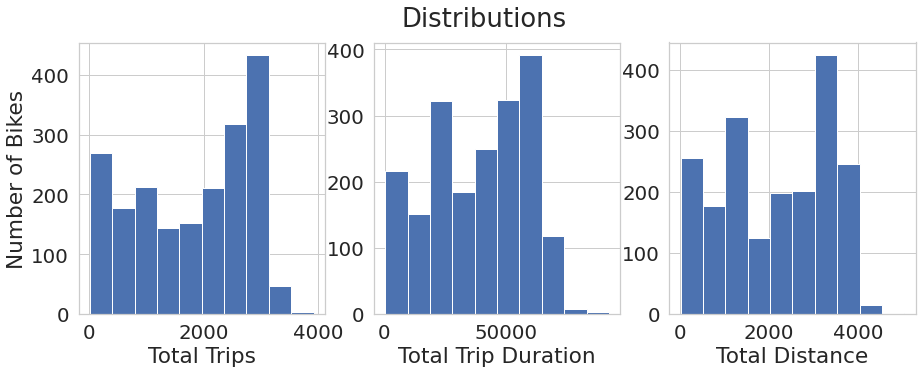

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(bikes['trips'])
plt.ylabel('Number of Bikes')
plt.xlabel('Total Trips')

plt.subplot(1,3,2)
plt.hist(bikes['total_time'])
plt.xlabel('Total Trip Duration')

plt.subplot(1,3,3)
plt.hist(bikes['total_distance'])
plt.xlabel('Total Distance')

plt.suptitle('Distributions')
plt.show()

These Distributions are very similar. This suggests that most of the trips are very similar as well.

### Closing Notes on EDA

The use pattern for this product is very regular. However bike inactivity seems to be quite irregular. Based upon a visual analysis, this problem may not be linearly separable. Therefore modeling would do well to take into account.